In [1]:
from Twister import Twister
import matplotlib.pyplot as plt

This notebook is a walkthrough of the Twister module, which utilizes Density Peaks Advanced Clustering to study the conformational free energy surfaces of organic molecules. Twister takes as input a COLVAR file generated by the Plumed software package. This COLVAR file should contain within a record of the MD trajectory through the values of the torsions which describe the conformational space, as well as a record of the final bias in each torsion at each of these points in conformational space.

The conformational space we are studying here is the Ramanchandran plot of alanine dipeptide, or the conformational free energy surface of alanine dipeptide in terms of its phi and psi angles. The COLVAR file in this directory is the product of 1 microsecond concurrent WTmetaD simulation of alanine dipeptide in vacuo, where we are biasing both phi and psi independently. The COLVAR file records in it's first column the time at which the simulation trajectory was sampled, the second and third columns contain the values of phi and psi at the indicated simulation time. The fourth and fifth columns contain the amount of bias on phi and psi at the values in columns 2 and 3.  

The COLVAR file should look something like this:

Twister can interpret COLVAR files with different numbers of torsions, and not all torsions have to biased during metadynamics. All COLVAR files must be ordered as above, with time, then torsion, and then bias columns. Twister interprets the COLVAR file using a biid variable. biid is a list with elements representing the torsions in the molecule. Biased torsions are indicated with a 1 and unbiased torsions with 0. The biid for the COLVAR file above thus looks like: 

In [2]:
biid = [1,1]

We instantiate our Twister object for Alanine Dipeptide with the biid variable:

In [3]:
AD = Twister(biid)

We read in the COLVAR file. The second argument specifies how many lines to skip at the start of the file.

In [4]:
AD.ColvarLoader('COLVAR2',5)

The ColvarLoader method automatically takes the last 2/3 of the COLVAR file, ignoring the start of the trajectory, where metadynamic bias is deposited at a high rate. In this demonstration notebook, we will be running our clustering on a further subset of just 5000 lines of the COLVAR file, so that the code can be demonstrated without excessive use of computational resources. The Downsample method returns a random, non-repeated sample of the current COLVAR attribute, which can be set using the ColvarSetter method. If it is desirable to use a larger dataset, change the argument in Downsample below.

In [5]:
Colvar5k = AD.DownSample(5000)
AD.ColvarSetter(Colvar5k)

Once the desired COLVAR variable is loaded in, it is time to run the main Clustering method. This method will run an initial DPA clustering on the biased distribution of datapoints in the conformation space defined by the torsions in COLVAR. The resulting densities will then be reweighed to account for the effect of the biases. DPA clustering will then be rerun on the reweighed densities. The cluster centers will correspond to density peaks, which we treat as maxima in the probability distribution. A Boltzmann inversion on all of the densities yields the free energies associated with each configuration, and the density peaks correspond to the conformational free energy minima. Running this method may take a few minutes, depending on your machine. The processor and memory demand increases with the square of the dataset size, so proceed with caution when increasing dataset size.

In [6]:
AD.Clustering()

The results of the Clustering attribute are stored in several attirbutes. The DPA object itself is stored in the DPAobj attribute. A summary of the properties of the cluster centers (free energy minima) are presented in the RefClusters attribute. The free energies generated are stored in energies, and the truncated free energies is stored in energies2 (see Note below). Similarly, the truncated Colvar, coordinates, and biases are stored in Colvar2, coords2 and bias2. 


Note: As part of a heuristic to assist DPA in avoiding unneccesary noise, any data points which present an energy over 100kJ/mol are removed from the dataset before a final reclustering. This eliminates noise generated by data points in irelevant high-energy regions. equivalent data points in the Colvar, coords, and biases attributes are also removed, so a coherent truncated dataset is stored. In low dimensional cases, such alanine dipeptide, here, it is highly unlikely that any points will have such low density/high energy, so the energy cut-off datasets are the same as the original ones. 

The RefClusters attribute contains the results for each of the cluster centers:

In [7]:
AD.RefClusters

{0: [-1.363335,
  0.845914,
  411.329163,
  394.508638,
  1691,
  0.6597042006785401,
  82253.0],
 1: [1.208069,
  -0.83565,
  399.215922,
  399.895675,
  1372,
  8.162208056911219,
  39216.6],
 2: [-2.73749, 2.923128, 405.558802, 401.436067, 1922, 0.0, 51678.2]}

The format of RefClusters is a dictionary containing an entry for each cluster center. The keys are indexed from 0. Each entry follows the same format: First, the coordinates of center are presented, then the biases. These are followed by the population of the cluster (the number of other points assigned to the cluster by DPA). this is followed by the free energy of the cluster in kJ/mol, and lastly the time the configuration was sampled by the simulation.

In [8]:
AD.RefClusters[0]

[-1.363335,
 0.845914,
 411.329163,
 394.508638,
 1691,
 0.6597042006785401,
 82253.0]

For alanine dipeptide, we can plot a per point FES using the coords2 and energies2 attributes

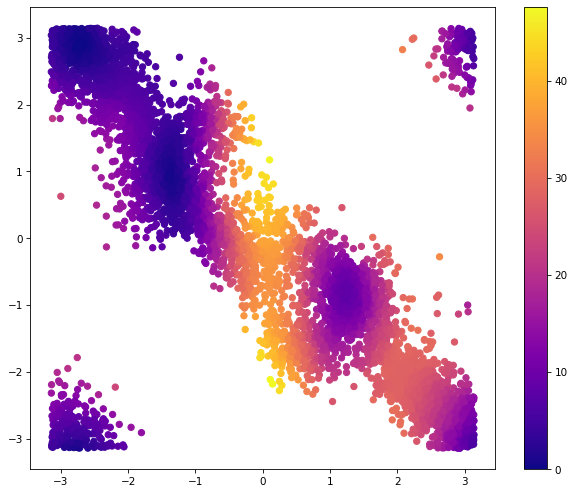

In [9]:
plt.figure(num = 1,figsize = (10,8), dpi =75)
plt.scatter(AD.coords2[:,0],AD.coords2[:,1], c = AD.energies2, cmap = 'plasma')
plt.colorbar()

We can annotate the above plot with information from RefClusters, for instance labelling the positions of the free energy minima with the free energy, rounded to 1 decimal place:

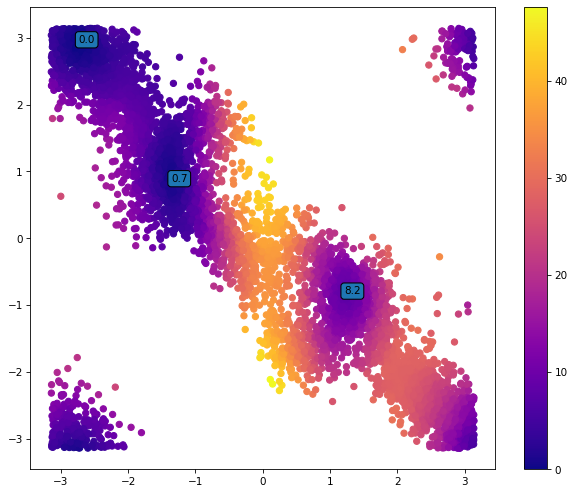

In [10]:
plt.figure(num = 1,figsize = (10,8), dpi =75)
plt.scatter(AD.coords2[:,0],AD.coords2[:,1], c = AD.energies2, cmap = 'plasma')
plt.colorbar()

for i in AD.RefClusters:
    plt.annotate(round(AD.RefClusters[i][5],1),(AD.RefClusters[i][0],AD.RefClusters[i][1]), color = 'black',bbox=dict(boxstyle="round"))

In order to determine that 5000 data points (or however many were used) is sufficient to capture the structure of the free energy surface, we repeat the clustering process on a smaller number of data points, and see if the cluster centers are in the same positions, and have the same relative free energies. We call this process Sampling Consistency Analysis and it is automated by the SCAnalysis method. It takes as input a list of dataset sizes to be tested. We will start at 500 data points, and add 500 at each iteration until we arrive at 4500. Be aware that this process repeats the clustering process from scratch for each dataset size, and can thus be quite time-consuming.

In [11]:
samplerange = range(500,5000,500)

AD.SCAnalysis(samplerange)

The results of the analysis are stored in the FAdata attribute.

In [12]:
dlist = AD.FAdata[0]
elist = AD.FAdata[1]
nlist = AD.FAdata[2]
clist = AD.FAdata[3]
cdlist = AD.FAdata[4]

All the results are lists where each member corresponds to one of datasets specified in samplerange. 

dlist contains the mean separation of equivalent clusters between the smaller dataset and the complete dataset

elist contains the mean energy difference between between equivalent clusters in the smaller dataset and complete datasets

nlist contains the dataset sizes, essentially a duplicate of samplerange

clist contains the number of clusters observed during each run on a smaller dataset

cdlist contains the equivalent to RefClusters for each clustering run on the smaller dataset

First, a check on the number of clusters identified per dataset size. For alanine dipeptide, this should be 3 clusters. Due to the very small dataset sizes at the lower end of our sample range, we may observe anomalies. As long as the second half of the plot remains constant, this is a good sign.

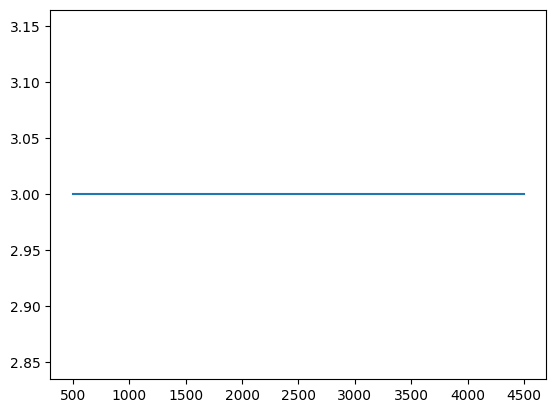

In [13]:
plt.plot(nlist,clist)

Next we observe how the mean separation and energy differences evolve as we get closer to the final datset size. In the case of alanine dipeptide, the 5000-point FES we created above is already very close to the theoretical optimum, so we expect, for the datasets closer to 5000, to see positional differences of less than 0.25 rad, and energy differences of less than 0.5 kJ/mol. Anomalies in the number of clusters identified in the plot above will be reflected in the plots below.

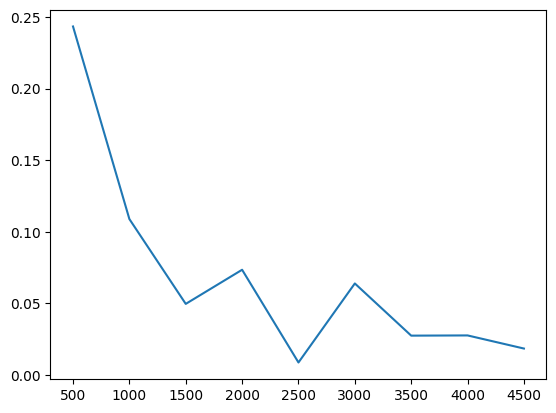

In [14]:
plt.plot(nlist,dlist)

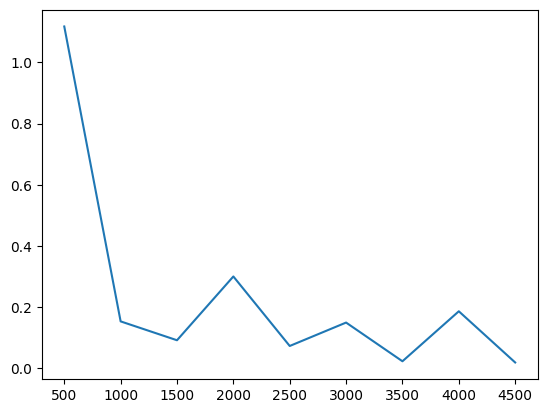

In [15]:
plt.plot(nlist,elist)

This notebook worked through the trivial two-dimensional case of alanine dipeptide, using a small number of data points to illustrate the working principles of Twister in a cheap and visually accessible way. It should be noted that things get more difficult when considering cases where the conformational space is higher dimensional (a molecule with more torsions). Firstly, as the dimensionality grows, so does the number of data points required to map out the free energy surface. Secondly, when the dimensionality is higher than 2, a complete visualization of the free energy surface in terms of every torsion becomes impossible. In those cases, the results of the Sampling Consistency Analysis become even more important when evaluating the quality of the results.

In this case study, all of the default parameters were used. However Twister can accept custom distance metric in the attribute metric, for determining the separation between two points in the conformation space, should the default Euclidean metric not be appropriate. All energy calculations assume a simulation temperature of 300 K, unless a temperature is specified in the T attribute. For noise reduction, densities calculated by DPA are smoothed over a radius of 0.1 rad by default. This can be modified by changing attribute smoothrad. Note that increasing this radius comes with increased computational cost and reduced spatial resolution.